<a href="https://colab.research.google.com/github/Praneeth-18/End-to-end-dependencies/blob/main/End_to_end_dependencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Buisness Objective
When we were updating Uber fare price prediction algorithm, using the number of parellel rides and weather condition (Refer the following Notebook for details : https://colab.research.google.com/drive/1F3jAfBr09KIIFqQBSzfT8Ri_OJo507Si?usp=sharing). We found that after training the models on new set of features the feature imporance of the 2 latent variables weren't as expected. As per buissness logic found on https://www.uber.com/en-GB/blog/uber-dynamic-pricing/, we know that the number of parellel rides should have a higher importance then the weather condition. As the reason for surge charge is parellel rides and not weather, the relation is bad weather causes more people to book cabs.
Our guess for this behviour of the model is that the distribution of data in these 2 columns has something to do with it.
The our goal for this experimentation is to see if by tweeking the distribution of the data based on the latent variables, will it be possible for us to improve the model's performance and correct the order of feature importance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=54e38501a34418b58b59dc091d2830627293eb4e07e476b435a0a0b6dcd287d1
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import  time
from pyod.models.knn import KNN
from sklearn.preprocessing import LabelEncoder
import datetime

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#read all uber data and combine them
#load uber data
df1 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_clean_preclustering_datetime_split.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/synthetic_uber_data_2016.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/synthetic_uber_data_2017.csv')

#combining all 3 uber data
uber_data = pd.concat([df1,df2,df3],axis=0)
uber_data.reset_index(drop=True,inplace=True)


In [ ]:
#load the weather data
weather_data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/combined_weather_nyc_2009_2017.csv')

In [ ]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform the 'icon' column
some = label_encoder.fit_transform(weather_data['icon'])

In [ ]:
label_encoder.classes_

array(['clear-day', 'cloudy', 'fog', 'partly-cloudy-day', 'rain', 'snow',
       'wind'], dtype=object)

In [ ]:
#function used for adjusting the price as per inflation
def adjust_fare_inflation(df,inflation=0.025):
  # Current year
  current_year = datetime.datetime.now().year
  # Calculate the difference in years and update the fare
  df['updated_fare_amount'] = df.apply(lambda row: row['fare_amount'] * (1 + inflation) ** (current_year - row['year']), axis=1)
  #getting rid of the old fare amount
  df.drop('fare_amount',axis=1,inplace=True)

def add_no_of_parellel_trips_latent_variable(df):
  # Group by year, month, day, and hour and count the number of occurrences
  group_sizes = df.groupby(['year', 'month', 'day', 'hour']).size().reset_index(name='no_parellel_rides')

  # Merge the group size information back into the original DataFrame
  uber_parellel_rides = pd.merge(df, group_sizes, on=['year', 'month', 'day', 'hour'], how='left')
  return uber_parellel_rides

def remove_outliers(df):
  #code generated by chatGPT
  # Assuming 'df' is your DataFrame and 'feature_columns' is a list of feature column names
  X = df.drop(['year','date','time','seconds','minutes'],axis=1)

  # Initialize the KNN model for outlier detection
  clf = KNN()

  # Fit the model on the data
  clf.fit(X)

  # Get the outlier scores for each data point
  outlier_scores = clf.decision_scores_

  # You can use a threshold to classify data points as outliers or inliers
  # For example, let's use the mean of the outlier scores as the threshold
  threshold = outlier_scores.mean()

  # Mark data points as outliers if their scores are greater than the threshold
  is_outlier = outlier_scores > threshold

  # Filter out the outliers from the DataFrame
  cleaned_df = df[~is_outlier]

  print(f"Original DataFrame size: {df.shape}")
  print(f"Cleaned DataFrame size: {cleaned_df.shape}")
  return cleaned_df

def join_weather_data(uber_data,weather_data):
  df_weather = weather_data[['datetime','icon']]

  #performing label encoding on icon

  # Initialize the LabelEncoder
  label_encoder = LabelEncoder()

  # Fit the label encoder and transform the 'icon' column
  df_weather['icon_encoded'] = label_encoder.fit_transform(df_weather['icon'])
  # Perform an inner join on the 'date' column
  df_weather2 = df_weather[['datetime','icon_encoded']]
  #renaming column so the join operation can performed
  df_weather2 = df_weather2.rename({'datetime':'date'},axis=1)
  uber_with_weather = pd.merge(uber_data, df_weather2, on='date', how='inner')
  return uber_with_weather

def preprocess_data(uber,weather):
  #adjust the price for inflation
  adjust_fare_inflation(uber)
  #add parellel rides information
  uber_parelle_rides = add_no_of_parellel_trips_latent_variable(uber)
  #addweather information
  uber_with_weather=join_weather_data(uber_parelle_rides,weather)
  return uber_parelle_rides,uber_with_weather


def split_data(df):
  X = merged_uber_parelle_rides_weather.drop(['year','updated_fare_amount','date','time'],axis=1)
  scaler = StandardScaler()
  # Fit the scaler to the data and transform it
  X_scaled = scaler.fit_transform(X)
  y = merged_uber_parelle_rides_weather['updated_fare_amount']
  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
  return X_train, X_test, y_train, y_test


def evaluate_regression_model(y_test,y_pred):
  # Evaluating the model using different techniques
  # Calculate metrics
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Print metrics
  print(f"Mean Squared Error (MSE): {mse:f}")
  print(f"Mean Absolute Error (MAE): {mae:f}")
  print(f"R-squared (R2): {r2:f}")
  return mse,mae,r2

def plot_res_reg(y_test,y_pred):
  residuals = y_test - y_pred
  plt.figure(figsize=(10, 6))
  sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
  plt.title('Residuals Plot')
  plt.xlabel('Predicted Values')
  plt.ylabel('Residuals')
  plt.axhline(y=0, color='grey', linestyle='--')
  plt.show()

  # Visualize the model fit
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
  plt.title('Actual vs. Predicted Values')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.show()


In [ ]:
#removing outlier from uber
cleaned_uber = remove_outliers(uber_data)
#performing all the necessary preprocessing steps
uber_data_parellel_rides,uber_data_parellel_rides_weather=preprocess_data(cleaned_uber,weather_data)

Original DataFrame size: (28243, 17)
Cleaned DataFrame size: (18705, 17)


<ipython-input-9-ad44a9bcc982>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['updated_fare_amount'] = df.apply(lambda row: row['fare_amount'] * (1 + inflation) ** (current_year - row['year']), axis=1)
<ipython-input-9-ad44a9bcc982>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('fare_amount',axis=1,inplace=True)
<ipython-input-9-ad44a9bcc982>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [ ]:
#renaming icon_endcoded to weather_condition
uber_data_parellel_rides_weather.rename({'icon_encoded':'weather_condition'},axis=1,inplace=True)

In [ ]:
# # #saving the clean files as csv
# uber_data_parellel_rides.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/all_uber_data_cleaned_with_parellel_ride.csv',index=False)
# uber_data_parellel_rides_weather.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/all_uber_data_cleaned_with_parellel_ride_and_weather.csv',index=False)

In [ ]:
#performing a train test split
X = uber_data_parellel_rides_weather.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
y = uber_data_parellel_rides_weather['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Defining functions and objects needed for Muller's Loop

In [ ]:
import pickle
#defining functions and objects needed for muller's loop
#Initialize an MLP Regressor
mlp = Sequential()
mlp.add(Dense(64, input_dim=14, activation='relu'))  # Input layer and the first hidden layer with 64 neurons
mlp.add(Dense(64, activation='relu'))  # Second hidden layer with 32 neurons
mlp.add(Dense(16, activation='relu'))  # Second hidden layer with 32 neurons
mlp.add(Dense(1, activation='linear'))  # Output layer with one neuron since it is regression
# Compile the model, using mean_sqaured_error as our loss function
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Initialize XGBRegressor
xg_reg = XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          n_estimators = 10)

#Initialize Linear Regressor
lr = LinearRegression()

#Initialize RandomForest Regressor

rf = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest
                               max_depth=None,    # Maximum depth of the trees
                               random_state=42)   # Seed for reproducibility

# Initialize the KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)

names = ["MLP Regressor", "Linear Regression", "Random Forest Regressor",
         "KNN Regressor", "XGBoost Regressor"]
#an array of all regressors
regressors =[mlp,lr,rf,knn_reg,xg_reg]
#variable to save the output all runs
mullers_iterations={name:[] for name in names}

def initialize_mlp(X):
    #hnadling different input dim
    #Initialize an MLP Regressor
    mlp = Sequential()
    mlp.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    mlp.add(Dense(64, activation='relu'))
    mlp.add(Dense(16, activation='relu'))
    mlp.add(Dense(1, activation='linear'))
    # Compile the model, using mean_sqaured_error as our loss function
    mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    #update the regressors
    regressors.pop(0)
    regressors.insert(0,mlp)

def run_muller_loop(mullers_iteration_name,X_train,y_train,X_test,y_test):
  initialize_mlp(X)
  min_mse = float('inf')
  max_class = ''
  result = {mullers_iteration_name:[]}
  # iterate over regressors
  for name, reg in zip(names, regressors):
      start_time = time.time()
      if name!='MLP Regressor':
        reg.fit(X_train, y_train)
      else:
        #special case for handling MLP using Keras
        reg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

      y_pred = reg.predict(X_test)
      mse,mae,r2=evaluate_regression_model(y_test,y_pred)
      print(f'For {name} MSE {mse}, Training Time = {(time.time() - start_time):2f}')
      result[mullers_iteration_name].append({name:{'MSE':mse,'MAE':mae,'R2':r2}})
      if mse < min_mse:
          reg_best = reg
          min_mse = mse
          max_class = name
  #saving the result
  with open(f'/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/data_distribution_muller_result/{mullers_iteration_name}.pkl','wb') as f:
    pickle.dump(result,f)


  print(80*'-' )
  print('Best --> Regerssor = %s, Score (test, MSE) = %.2f' %(max_class, min_mse))
  return reg_best, result


## Base Model

In [ ]:
best_reg,result = run_muller_loop('NoUpScaling',X_train,y_train,X_test,y_test)

Epoch 1/5
468/468 [==============================] - 3s 5ms/step - loss: 14.9053 - val_loss: 7.1367
Epoch 2/5
468/468 [==============================] - 2s 4ms/step - loss: 5.6052 - val_loss: 4.6460
Epoch 3/5
468/468 [==============================] - 1s 3ms/step - loss: 5.3348 - val_loss: 4.5896
Epoch 4/5
468/468 [==============================] - 1s 3ms/step - loss: 5.2574 - val_loss: 4.5614
Epoch 5/5
117/117 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 5.598337
Mean Absolute Error (MAE): 1.711616
R-squared (R2): 0.632608
For MLP Regressor MSE 5.598336984245638, Training Time = 9.679459
Mean Squared Error (MSE): 4.514431
Mean Absolute Error (MAE): 1.619754
R-squared (R2): 0.703739
For Linear Regression MSE 4.5144314837645565, Training Time = 0.073391
Mean Squared Error (MSE): 3.925004
Mean Absolute Error (MAE): 1.494565
R-squared (R2): 0.742421
For Random Forest Regressor MSE 3.925003972731688, Training Time = 15.786146
Mean Squared Error (MSE): 6.795103
M

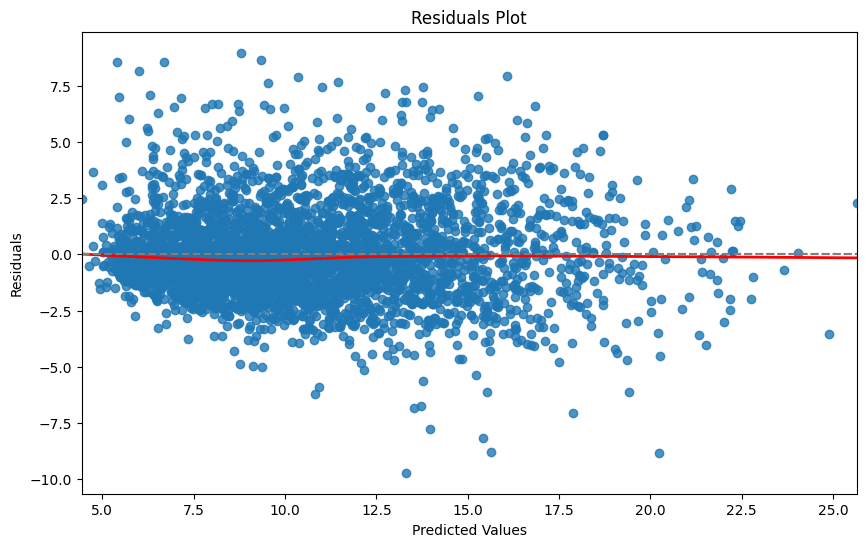

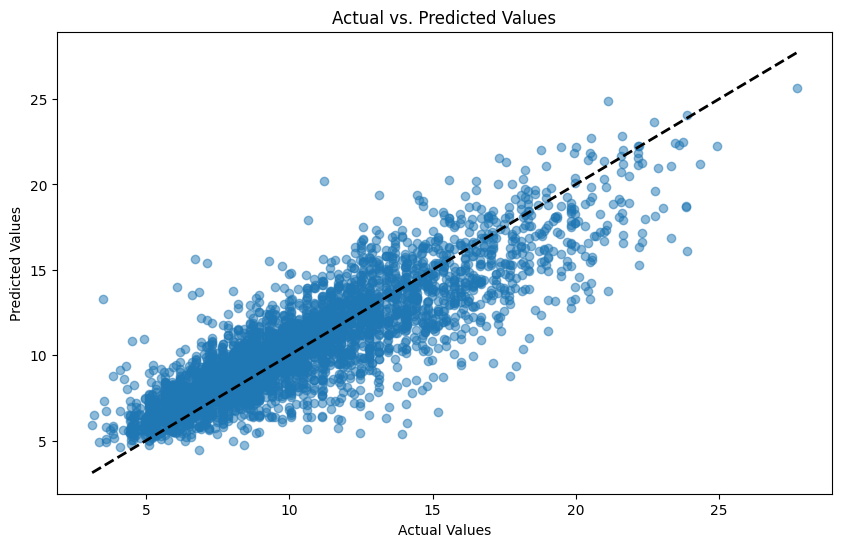

In [ ]:
#visualizing the result
y_pred = best_reg.predict(X_test)
plot_res_reg(y_test,y_pred)

## Feature Importance After Regression on base data

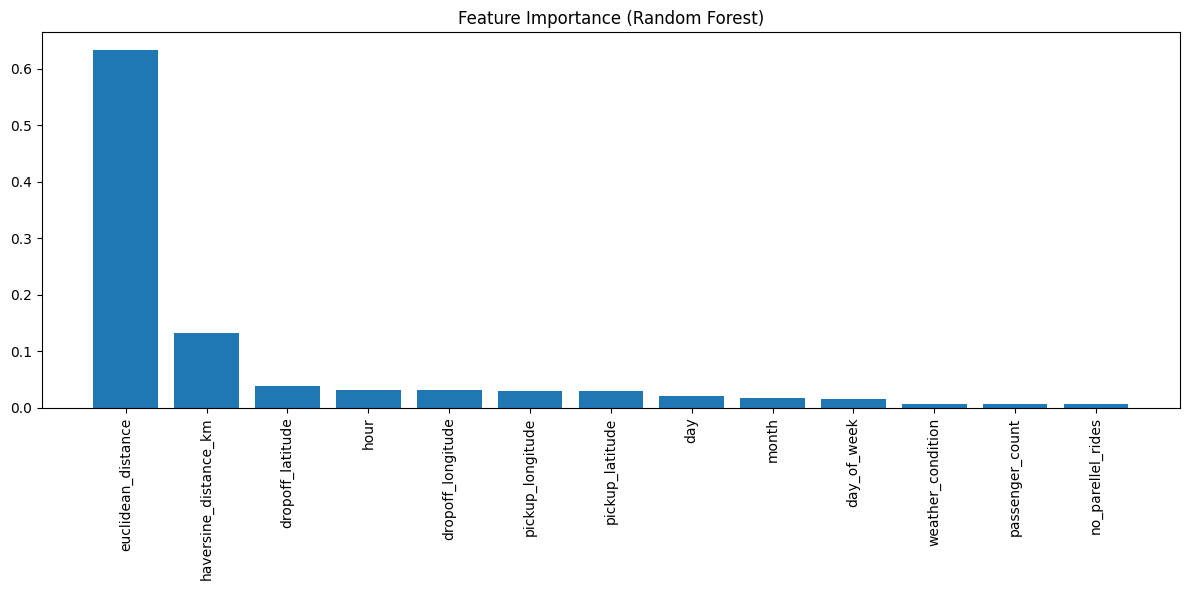

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

After training our model on the base data we have an MSE of 3.96 which is good, however the feature importance is off, weather condition is given more importance than the number of parellel rides.

Our guess is that the data in these 2 columns are nor properly distributed which is causing such a problem.

In [ ]:
uber_data_parellel_rides_weather['no_parellel_rides'].value_counts()

1    12405
2     4912
3     1149
4      208
5       25
6        6
Name: no_parellel_rides, dtype: int64

In [ ]:
uber_data_parellel_rides_weather['weather_condition'].value_counts()

3    7939
4    6769
0    3204
5     559
1     226
2       5
6       3
Name: weather_condition, dtype: int64

Our guess was correct , the data within in these 2 features are not evenly distributed, this could be causing this effect, lets see if we can address it .

# Upscaling

## Upcaling the Number of Parellel Rides

We will try to upscale the number of parellel rides such that we have even number for records for each value of number of parellel rides

In [ ]:
from imblearn.over_sampling import SMOTE

#performing a train test split
X = uber_data_parellel_rides_weather.drop(['year','updated_fare_amount','date','time','seconds','minutes'],axis=1)
#scaling the data
y = uber_data_parellel_rides_weather['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#combining the training split so that we can apply smote on it
X_train['updated_fare_amount'] = y_train
# Initialize the SMOTE object
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train.drop(['no_parellel_rides'],axis=1), X_train['no_parellel_rides'])

# Check the class distribution after SMOTE
print(f"Original class distribution: {X_train['no_parellel_rides'].value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")

#combining them
#now we will combine the smote data to make the main data
balanced_data_trips = X_train_smote.copy()
balanced_data_trips['no_parellel_rides'] =y_train_smote
#making sure the train and test set have the same order
X_train_new = balanced_data_trips.drop('updated_fare_amount',axis=1)
y_train_new = balanced_data_trips['updated_fare_amount']
X_train_new = X_train_new[X_test.columns]


Original class distribution: 1    9877
2    3977
3     916
4     171
5      17
6       6
Name: no_parellel_rides, dtype: int64
SMOTE class distribution: 1    9877
2    9877
4    9877
3    9877
5    9877
6    9877
Name: no_parellel_rides, dtype: int64


In [ ]:
best_reg,result2 = run_muller_loop('UpScalingParellelRides',X_train_new,y_train_new,X_test,y_test)

Epoch 1/5
1852/1852 [==============================] - 7s 3ms/step - loss: 5.2504 - val_loss: 4.8238
Epoch 2/5
1852/1852 [==============================] - 4s 2ms/step - loss: 3.8721 - val_loss: 4.7331
Epoch 3/5
1852/1852 [==============================] - 6s 3ms/step - loss: 3.7369 - val_loss: 5.1571
Epoch 4/5
1852/1852 [==============================] - 6s 4ms/step - loss: 3.5782 - val_loss: 4.6806
Epoch 5/5
117/117 [==============================] - 0s 3ms/step
Mean Squared Error (MSE): 4.513374
Mean Absolute Error (MAE): 1.592041
R-squared (R2): 0.703809
For MLP Regressor MSE 4.513373774660709, Training Time = 43.085481
Mean Squared Error (MSE): 4.730048
Mean Absolute Error (MAE): 1.677976
R-squared (R2): 0.689589
For Linear Regression MSE 4.730047563916045, Training Time = 0.067194
Mean Squared Error (MSE): 4.031901
Mean Absolute Error (MAE): 1.517625
R-squared (R2): 0.735405
For Random Forest Regressor MSE 4.031901347827599, Training Time = 69.024562
Mean Squared Error (MSE): 7.3

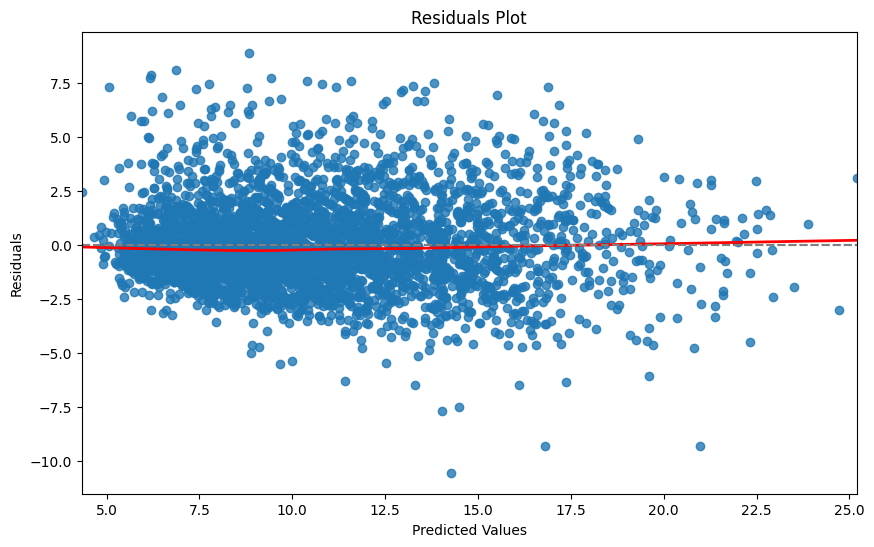

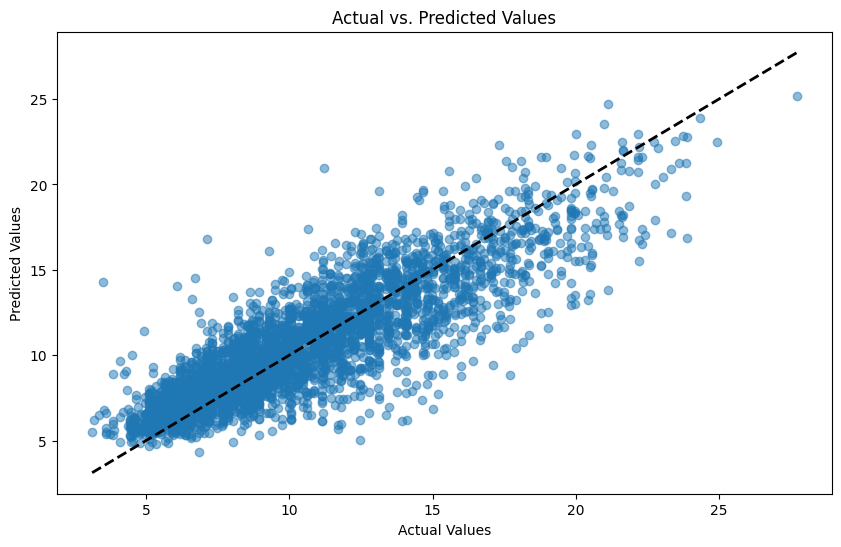

In [ ]:
#visualizing the result
y_pred = best_reg.predict(X_test)
plot_res_reg(y_test,y_pred)

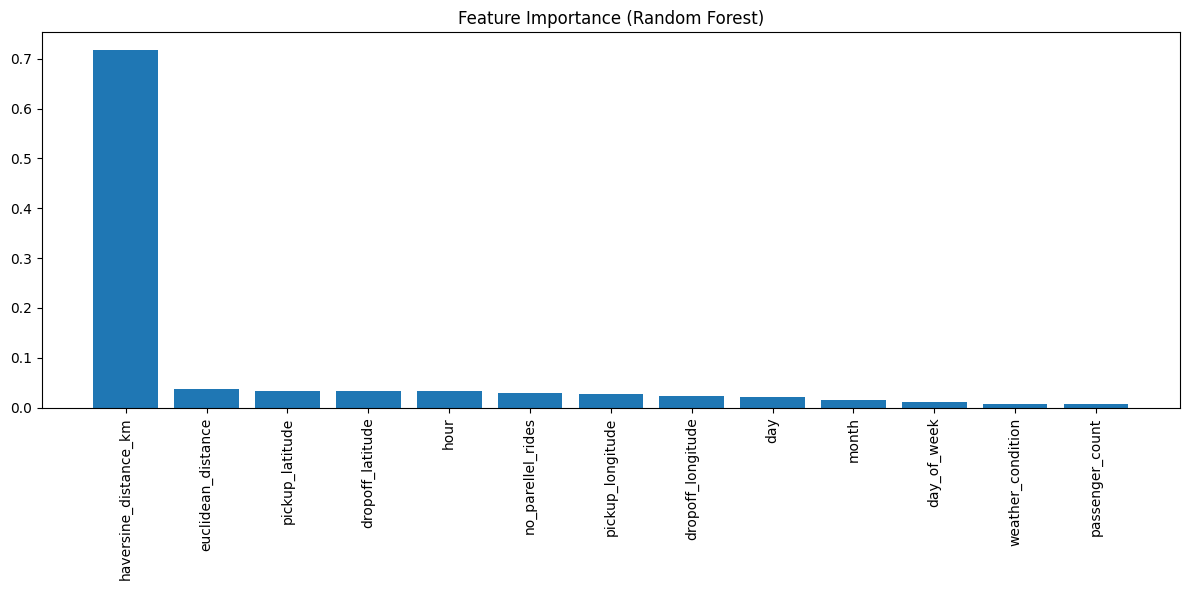

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

By Upscaling the no_parellel_rides we were able to increase its features importance, i.e. no_parellel_rides having more importance then weather data  however did take a small dump to the model performance, as our MSE is 4.03. We will further try to peform upscaling to see if we can further improve the performance.

However my guess is that to get MSE lower to 1,2 we would need to ask Uber for more data, such as number of drivers available when a trip was booked, as of now we have weather data at a daily level, to get better predictions we would need to incorporate weather data at an hourly level. The idea being that if there is only 1 driver availble and 2 passenger raise a cab request then even at 2 request surge charges will apply.

Additionally if on a day it rains at 7 pm then more people will book a cab, however during the reamining part of the day the weather will have negilible impact on demand.

## Upscaling Weather Condition Data - Attemp to improve performance

On the the no_parellel_rides upscaled data I will apply SMOTE one more time to upscale the weather

In [ ]:
# Initialize the SMOTE object
smote = SMOTE(random_state=42,k_neighbors=2)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(balanced_data_trips.drop(['weather_condition'],axis=1), balanced_data_trips['weather_condition'])

# Check the class distribution after SMOTE
print(f"Original class distribution: {X_train['weather_condition'].value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")

#combining them
#now we will combine the smote data to make the main data
balanced_data_trips_weather = X_train_smote.copy()
balanced_data_trips_weather['weather_condition'] =y_train_smote
#making sure the train and test set have the same order
X_train_new2 = balanced_data_trips_weather.drop('updated_fare_amount',axis=1)
y_train_new2 = balanced_data_trips_weather['updated_fare_amount']
X_train_new2 = X_train_new2[X_test.columns]


Original class distribution: 3    6309
4    5453
0    2546
5     458
1     190
2       5
6       3
Name: weather_condition, dtype: int64
SMOTE class distribution: 3    23734
0    23734
4    23734
1    23734
5    23734
2    23734
6    23734
Name: weather_condition, dtype: int64


In [ ]:
best_reg,result3 = run_muller_loop('UpScalingParellelRidesWeather',X_train_new2,y_train_new2,X_test,y_test)

Epoch 1/5
5192/5192 [==============================] - 15s 3ms/step - loss: 3.6151 - val_loss: 4.5843
Epoch 2/5
5192/5192 [==============================] - 13s 3ms/step - loss: 2.7638 - val_loss: 4.8060
Epoch 3/5
5192/5192 [==============================] - 15s 3ms/step - loss: 2.5971 - val_loss: 4.7250
Epoch 4/5
5192/5192 [==============================] - 14s 3ms/step - loss: 2.4499 - val_loss: 4.5068
Epoch 5/5
117/117 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 4.557507
Mean Absolute Error (MAE): 1.636781
R-squared (R2): 0.700912
For MLP Regressor MSE 4.557506975949046, Training Time = 83.772892
Mean Squared Error (MSE): 4.774729
Mean Absolute Error (MAE): 1.687859
R-squared (R2): 0.686657
For Linear Regression MSE 4.774728721355643, Training Time = 0.185373
Mean Squared Error (MSE): 4.149316
Mean Absolute Error (MAE): 1.543658
R-squared (R2): 0.727700
For Random Forest Regressor MSE 4.14931567920841, Training Time = 214.970136
Mean Squared Error (MSE):

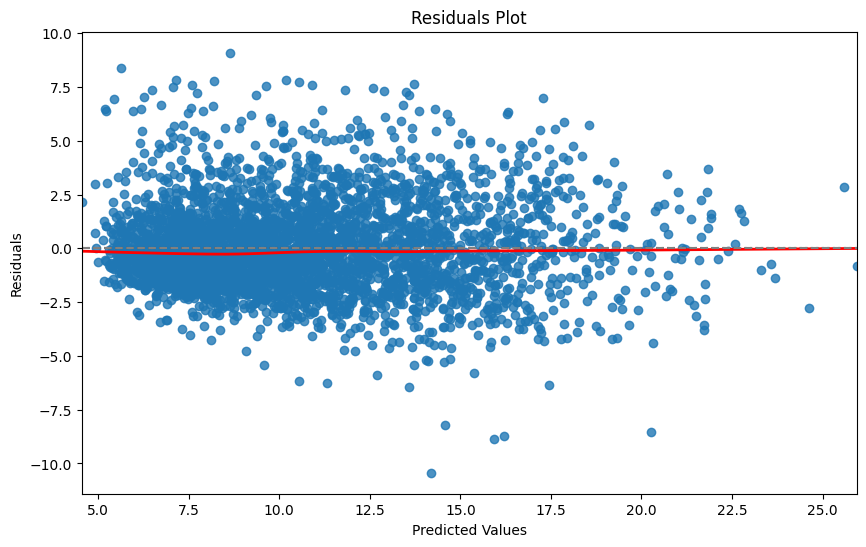

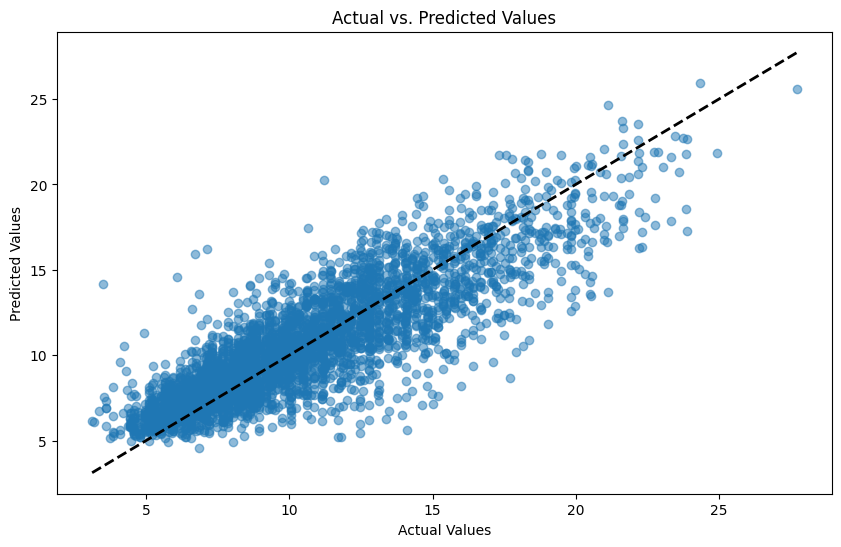

In [ ]:
#visualizing the result
y_pred = best_reg.predict(X_test)
plot_res_reg(y_test,y_pred)

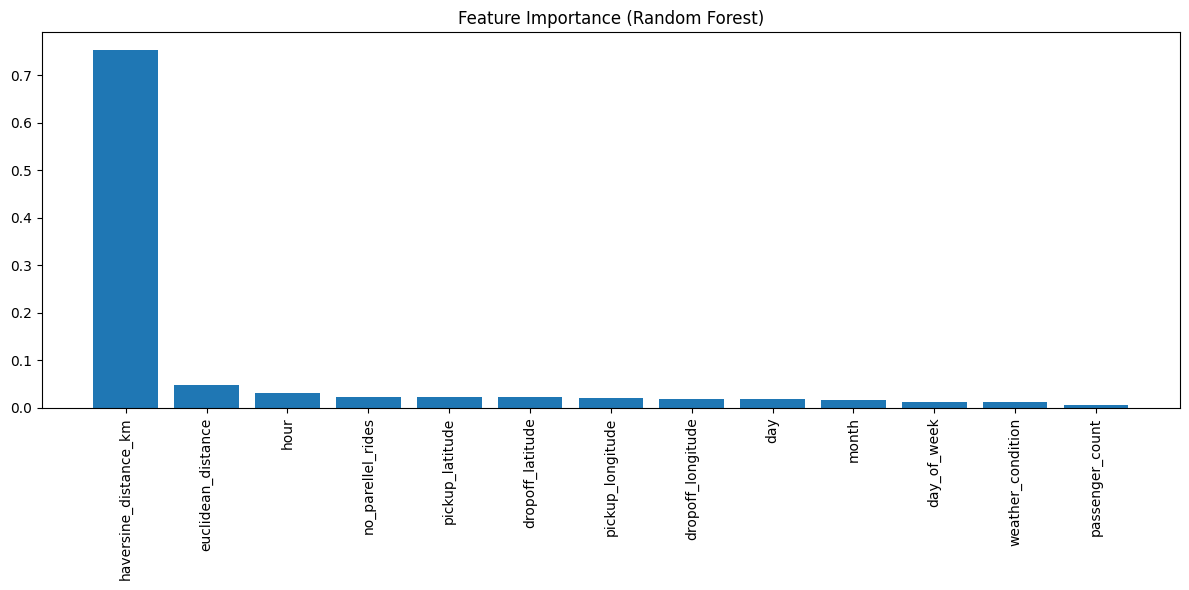

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

We can see the the the model performace further decreases and we didn't gain an insights in terms of explainability.

Our main guess on why this is happening is case there are values for weather data for which we have way too little information and we are then sampling it to a really large number this is confusing the model.

So to try to solve it, to see if we can improve performance.

# Data Engineering before we do another se of Scaling

1. For parellel rides instead of explicitly specifying the number of parellel rides, we will use an indicator which will be 1 when count is greater than equal to 3 or else it will 0.
2. For weather data, we have very few records of particular weather conditions, so we will drop those rows (windy,snow, fog, etc). The we will be left with cloudy, clear, partly cloudy and rain. We will use the same logic as we did for parellel rides and replace it with a rain indicator, which will be when there is rain else it will be 0.

3. Additionally we sae above there are a number of features present which have very insignificant feature improtance, so we will drop them before training, in an attempt to better fit the model and prevent overfitting.

In [ ]:
uber_data_parellel_rides_weather['parellel_ride_indicator'] = list(map(lambda x: 3 if x >= 3 else x, uber_data_parellel_rides_weather['no_parellel_rides']))
# Drop rows where 'weather_condition' is 5, 2, or 6
uber_data_parellel_rides_weather = uber_data_parellel_rides_weather[~uber_data_parellel_rides_weather['weather_condition'].isin([5, 2, 6])].copy()
uber_data_parellel_rides_weather['rain_indicator'] = list(map(lambda x: 1 if x == 4 else 0, uber_data_parellel_rides_weather['weather_condition']))


In [ ]:
uber_data_parellel_rides_weather.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'euclidean_distance', 'date',
       'time', 'day_of_week', 'haversine_distance_km', 'year', 'month', 'day',
       'hour', 'minutes', 'seconds', 'updated_fare_amount',
       'no_parellel_rides', 'weather_condition', 'parellel_ride_indicator',
       'rain_indicator'],
      dtype='object')

## Upscaling on Parellel Rides Indicator - After feature engineering

In [ ]:
#performing a train test split
X = uber_data_parellel_rides_weather.drop(['year','updated_fare_amount','date','time','seconds','minutes','no_parellel_rides','weather_condition','month','day','passenger_count'],axis=1)
#scaling the data
y = uber_data_parellel_rides_weather['updated_fare_amount']
#columns to scale
s= ['pickup_longitude','pickup_latitude','dropoff_longitude','euclidean_distance','haversine_distance_km']
scaler = StandardScaler()
X[s]=scaler.fit_transform(X[s])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#combining the training split so that we can apply smote on it
X_train['updated_fare_amount'] = y_train
# Initialize the SMOTE object
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train.drop(['parellel_ride_indicator'],axis=1), X_train['parellel_ride_indicator'])

# Check the class distribution after SMOTE
print(f"Original class distribution: {X_train['parellel_ride_indicator'].value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")

#combining them
#now we will combine the smote data to make the main data
balanced_data_trips = X_train_smote.copy()
balanced_data_trips['parellel_ride_indicator'] =y_train_smote
#making sure the train and test set have the same order
X_train_new = balanced_data_trips.drop('updated_fare_amount',axis=1)
y_train_new = balanced_data_trips['updated_fare_amount']
X_train_new = X_train_new[X_test.columns]

Original class distribution: 1    9596
2    3832
3    1082
Name: parellel_ride_indicator, dtype: int64
SMOTE class distribution: 1    9596
2    9596
3    9596
Name: parellel_ride_indicator, dtype: int64


In [ ]:
best_reg,result4 = run_muller_loop('UpScalingParellelRidesIndicator',X_train_new,y_train_new,X_test,y_test)

Epoch 1/5
900/900 [==============================] - 4s 3ms/step - loss: 6.8867 - val_loss: 4.8313
Epoch 2/5
900/900 [==============================] - 4s 4ms/step - loss: 4.2402 - val_loss: 4.5562
Epoch 3/5
900/900 [==============================] - 3s 3ms/step - loss: 4.2063 - val_loss: 4.4965
Epoch 4/5
900/900 [==============================] - 2s 3ms/step - loss: 4.1367 - val_loss: 4.6593
Epoch 5/5
114/114 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 4.506226
Mean Absolute Error (MAE): 1.640946
R-squared (R2): 0.711079
For MLP Regressor MSE 4.506226203054285, Training Time = 15.468725
Mean Squared Error (MSE): 4.744916
Mean Absolute Error (MAE): 1.645876
R-squared (R2): 0.695775
For Linear Regression MSE 4.744915811985737, Training Time = 0.024889
Mean Squared Error (MSE): 4.064828
Mean Absolute Error (MAE): 1.509211
R-squared (R2): 0.739380
For Random Forest Regressor MSE 4.064828186052921, Training Time = 28.458401
Mean Squared Error (MSE): 5.610842
Me

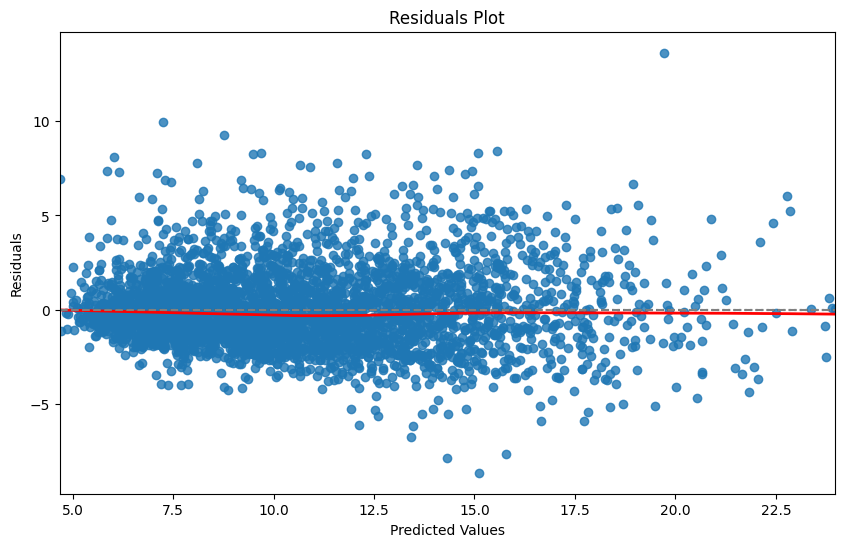

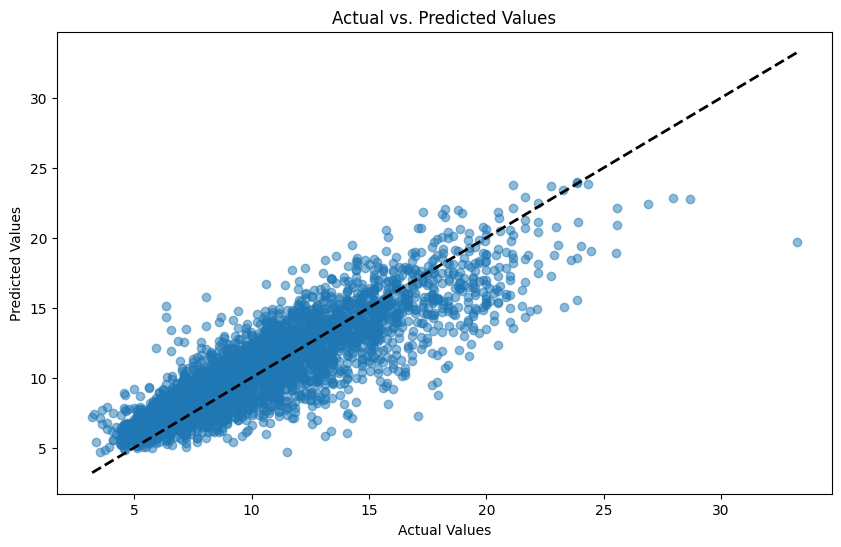

In [ ]:
#visualizing the result
y_pred = best_reg.predict(X_test)
plot_res_reg(y_test,y_pred)

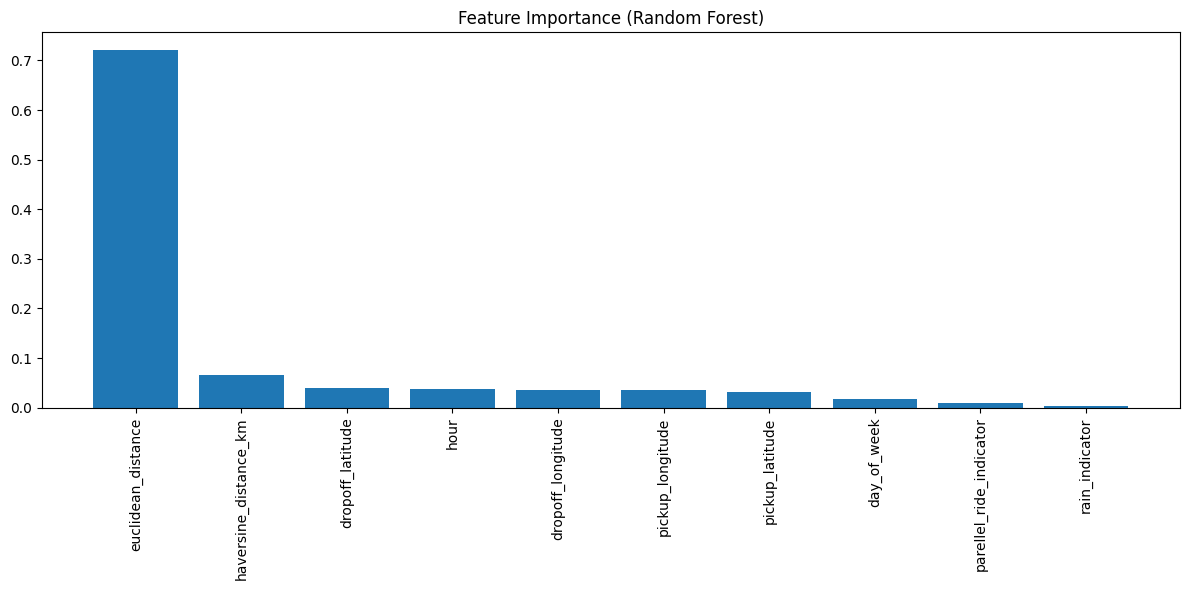

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

After performing our dataengineering steps and then them performing Scaling on parellel_ride_indicator  rather than the count, we were able to get the same model performance the level of feature importance, as we did with the parellel rides count however this time we are using fewer features, making it a better model.

## Upscaling on Parellel Ride Indicator and Rain Indicator

In [ ]:
# Initialize the SMOTE object
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(balanced_data_trips.drop(['rain_indicator'],axis=1), balanced_data_trips['rain_indicator'])

# Check the class distribution after SMOTE
print(f"Original class distribution: {X_train['rain_indicator'].value_counts()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")

#combining them
#now we will combine the smote data to make the main data
balanced_data_trips_weather = X_train_smote.copy()
balanced_data_trips_weather['rain_indicator'] =y_train_smote
#making sure the train and test set have the same order
X_train_new2 = balanced_data_trips_weather.drop('updated_fare_amount',axis=1)
y_train_new2 = balanced_data_trips_weather['updated_fare_amount']
X_train_new2 = X_train_new2[X_test.columns]


Original class distribution: 0    9151
1    5359
Name: rain_indicator, dtype: int64
SMOTE class distribution: 0    20349
1    20349
Name: rain_indicator, dtype: int64


In [ ]:
best_reg,result5 = run_muller_loop('UpScalingParellelIndicatorWeatherIndicator',X_train_new2,y_train_new2,X_test,y_test)

Epoch 1/5
1272/1272 [==============================] - 5s 3ms/step - loss: 6.3385 - val_loss: 4.4803
Epoch 2/5
1272/1272 [==============================] - 3s 2ms/step - loss: 4.0494 - val_loss: 4.4424
Epoch 3/5
1272/1272 [==============================] - 3s 2ms/step - loss: 3.9826 - val_loss: 4.4480
Epoch 4/5
1272/1272 [==============================] - 4s 3ms/step - loss: 3.9271 - val_loss: 4.3611
Epoch 5/5
114/114 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 4.320526
Mean Absolute Error (MAE): 1.555574
R-squared (R2): 0.722985
For MLP Regressor MSE 4.320526109132212, Training Time = 19.190694
Mean Squared Error (MSE): 4.748890
Mean Absolute Error (MAE): 1.648906
R-squared (R2): 0.695520
For Linear Regression MSE 4.748890376411903, Training Time = 0.034124
Mean Squared Error (MSE): 4.043110
Mean Absolute Error (MAE): 1.515385
R-squared (R2): 0.740772
For Random Forest Regressor MSE 4.043110220190499, Training Time = 45.443863
Mean Squared Error (MSE): 5.8

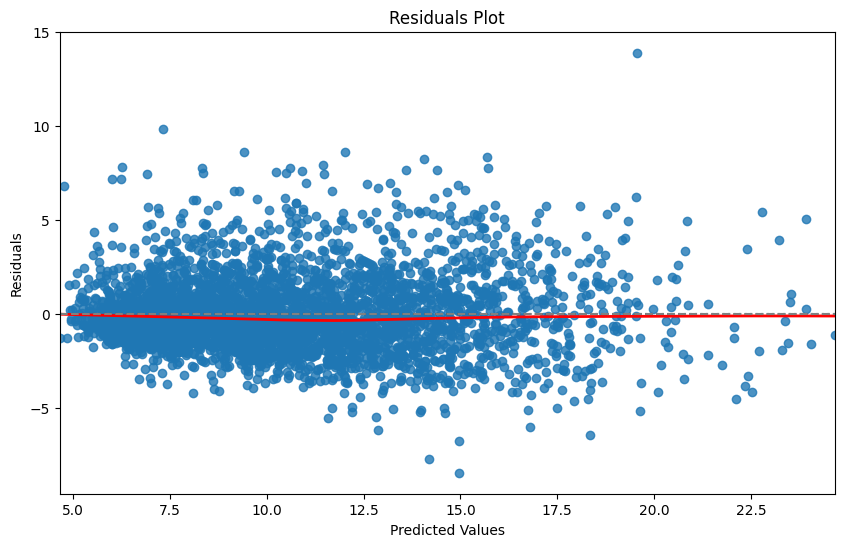

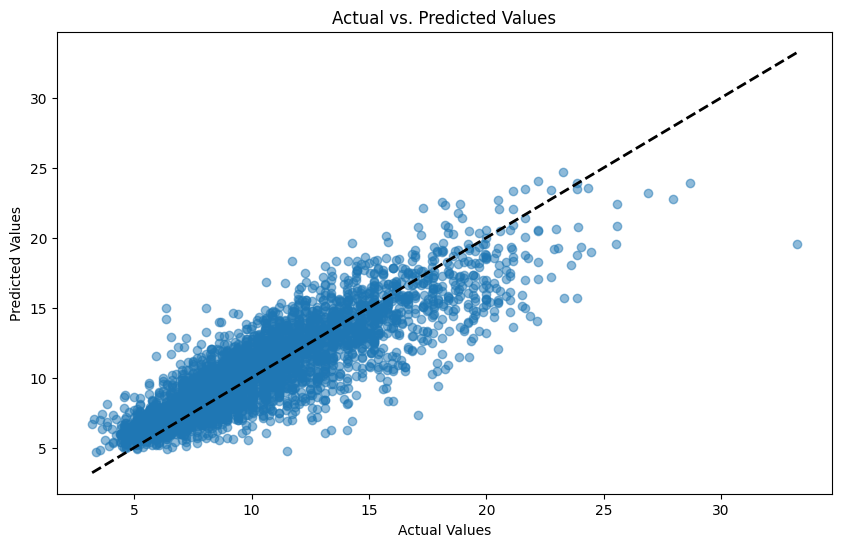

In [ ]:
#visualizing the result
y_pred = best_reg.predict(X_test)
plot_res_reg(y_test,y_pred)

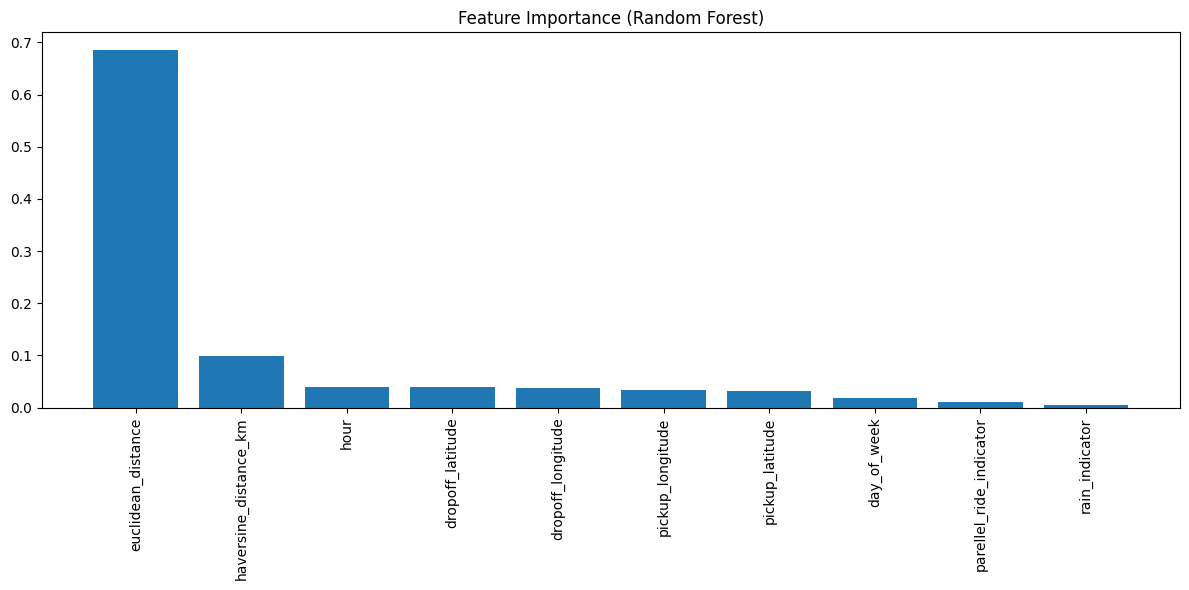

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

After performing upscaling on the parellel rides indicator and rain indicators , we got an MSE of 4.04, which is equivalent to one which we got when we performed the scaling on the number of parellel ride. However in terms of feature importance the the parelle rides ahve a lower feature importance, cause of this reason we belive give the data the model trained on the upscaled parellel rides count would be the better model.

## Future Scope

To further improve the models performance, we would require more granular uber and weather data, as explained above.

Data such as number of drivers available when a trip was booked, as of now we have weather data at a daily level, to get better predictions we would need to incorporate weather data at an hourly level. The idea being that if there is only 1 driver availble and 2 passenger raise a cab request then even at 2 request surge charges will apply.

Additionally if on a day it rains at 7 pm then more people will book a cab, however during the reamining part of the day the weather will have negilible impact on demand.


# Down Sampling

In [ ]:
#Importing the data
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/all_uber_data_cleaned_with_parellel_ride_and_weather.csv')
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,date,time,day_of_week,haversine_distance_km,year,month,day,hour,minutes,seconds,updated_fare_amount,no_parellel_rides,weather_condition
0,-73.999817,40.738354,-73.999512,40.723217,1.0,0.015140,2015-05-07,1900-01-01 19:52:06,3,1.683323,2015,5,7,19,52,6,9.366472,4,0
1,-73.980225,40.735176,-74.010918,40.701797,1.0,0.045345,2015-05-07,1900-01-01 08:12:06,3,4.524005,2015,5,7,8,12,6,15.610787,1,0
2,-73.972290,40.750214,-73.986351,40.755245,1.0,0.014934,2015-05-07,1900-01-01 10:46:55,3,1.309906,2015,5,7,10,46,55,9.990904,1,0
3,-73.985352,40.768566,-73.992928,40.734158,1.0,0.035233,2015-05-07,1900-01-01 22:23:18,3,3.878915,2015,5,7,22,23,18,16.235219,2,0
4,-73.989372,40.729816,-73.978935,40.744709,1.0,0.018186,2015-05-07,1900-01-01 21:29:50,3,1.874975,2015,5,7,21,29,50,8.742041,2,0


In [ ]:
#Dropping non predective columns
data = data.drop(['date', 'time', 'minutes', 'seconds', 'year'], axis=1)

In [ ]:
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,day_of_week,haversine_distance_km,month,day,hour,updated_fare_amount,no_parellel_rides,weather_condition
0,-73.999817,40.738354,-73.999512,40.723217,1.0,0.015140,3,1.683323,5,7,19,9.366472,4,0
1,-73.980225,40.735176,-74.010918,40.701797,1.0,0.045345,3,4.524005,5,7,8,15.610787,1,0
2,-73.972290,40.750214,-73.986351,40.755245,1.0,0.014934,3,1.309906,5,7,10,9.990904,1,0
3,-73.985352,40.768566,-73.992928,40.734158,1.0,0.035233,3,3.878915,5,7,22,16.235219,2,0
4,-73.989372,40.729816,-73.978935,40.744709,1.0,0.018186,3,1.874975,5,7,21,8.742041,2,0


Nextstep would be putting aside some test data to mimic a real world senario where we test on incoming unseen data.

## **Making the Train Test Split**

In [ ]:
#Stratified Train Test Split
from sklearn.model_selection import train_test_split
X, y = data.drop('updated_fare_amount', axis=1), data['updated_fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = X[['weather_condition', 'no_parellel_rides']])

In [ ]:
#storing the test data
downsample_test_data = pd.concat([X_test, y_test], axis=1)

In [ ]:
#saving the test data for backup
downsample_test_data.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/downsample_test_data.csv')

In [ ]:
#value Counts after Train Test Split
X_train.value_counts('no_parellel_rides')

no_parellel_rides
1    9923
2    3929
3     920
4     167
5      20
6       5
dtype: int64

In [ ]:
#value Counts after Train Test Split
X_train.value_counts('weather_condition')

weather_condition
3    6351
4    5415
0    2564
5     448
1     180
2       4
6       2
dtype: int64

In [ ]:
#combining the training data
data_tobe_sampled = pd.concat([X_train, y_train], axis=1)

As we can see some categories in the training data for the number of rides or weather is less than or equal to 20 which is really small amount of information to learn from.

Down Scaling Logic:

We will try and make every category to 2000 to set aside the bias due to overpresentation of a category. To ahieve this we are going to take 2 steps:

    1) Random Downsampling the data with more than 2000 entries
        - I would have preferd to do this removing duplicates rather than random down sampling but that would mean we
          have a concrete measure to find out 'near duplicates' which isn't the case so we anyway go ahead with the random subsampling
    2) Upsampling the data with less than 2000 entries using SMOTE

## **DownSampling based on Number of Parallel Rides**

In [ ]:
# Downsampling the classes with access data
from sklearn.model_selection import train_test_split

# Function to downsample the category
def downsample_category(df, category_value):
    # Filter the category
    df_filtered = df[df['no_parellel_rides'] == category_value]
    df_downsampled = df_filtered.sample(n=2000, random_state=42)

    return df_downsampled

# Downsample categories 1 and 2
downsampled_1 = downsample_category(data_tobe_sampled, 1)
downsampled_2 = downsample_category(data_tobe_sampled, 2)

# Combine the downsampled data with the rest of the data excluding original categories 1 and 2
remaining_data = data_tobe_sampled[~data_tobe_sampled['no_parellel_rides'].isin([1, 2])]
downsampled_data = pd.concat([downsampled_1, downsampled_2, remaining_data])

# Check new distribution
new_category_distribution = downsampled_data['no_parellel_rides'].value_counts().sort_index()

In [ ]:
#data distribution after down sampling
new_category_distribution

1    2000
2    2000
3     920
4     167
5      20
6       5
Name: no_parellel_rides, dtype: int64

In [ ]:
#upsampling the caegories with less than 2000 entries using SMOTE
from imblearn.over_sampling import SMOTE

# Preparing the dataset for SMOTE
# Selecting numerical features for SMOTE
smote_features = downsampled_data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                       'passenger_count', 'euclidean_distance', 'haversine_distance_km', 'updated_fare_amount', 'weather_condition', 'month', 'day', 'hour', 'day_of_week']]
smote_target = downsampled_data['no_parellel_rides']

# Applying SMOTE for each category that needs to be upsampled to 2000
smote = SMOTE(sampling_strategy={3: 2000, 4: 2000, 5: 2000, 6: 2000}, random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(smote_features, smote_target)

# Checking the new distribution after upsampling
upsampled_data_distribution = pd.Series(y_resampled).value_counts().sort_index()

upsampled_data_distribution

1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
Name: no_parellel_rides, dtype: int64

In [ ]:
no_parellel_rides_downsampled = pd.concat([X_resampled, y_resampled], axis = 1)

In [ ]:
no_parellel_rides_downsampled.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/no_parellel_rides_downsampled.csv')

In [ ]:
no_parellel_rides_downsampled.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,haversine_distance_km,updated_fare_amount,weather_condition,month,day,hour,day_of_week,no_parellel_rides
0,-73.954158,40.766377,-73.973043,40.747703,2.0,0.026559,2.615692,13.179513,4,3,27,17,4,1
1,-73.972933,40.758833,-73.981212,40.747227,1.0,0.014256,1.466897,8.408917,3,6,28,19,1,1
2,-74.009511,40.740460,-74.012438,40.717105,1.0,0.023538,2.608643,11.152737,5,2,3,12,6,1
3,-73.976482,40.739530,-73.983785,40.742627,1.0,0.007933,0.705086,6.589955,4,5,16,21,2,1
4,-73.962029,40.763802,-73.973480,40.762756,1.0,0.011499,0.971448,6.244315,4,4,9,2,3,1


## **DownSampling based on Weather**

In [ ]:
# Downsampling the classes with access data
from sklearn.model_selection import train_test_split

# Function to downsample the category
def downsample_category(df, category_value):
    # Filter the category
    df_filtered = df[df['weather_condition'] == category_value]
    df_downsampled = df_filtered.sample(n=2000, random_state=42)

    return df_downsampled

# Downsample categories 0, 3 and 4
w_downsampled_1 = downsample_category(data_tobe_sampled, 0)
w_downsampled_2 = downsample_category(data_tobe_sampled, 3)
w_downsampled_3 = downsample_category(data_tobe_sampled, 4)

# Combine the downsampled data with the rest of the data excluding original categories 1 and 2
w_remaining_data = data_tobe_sampled[~data_tobe_sampled['weather_condition'].isin([0, 3, 4])]
downsampled_data = pd.concat([w_downsampled_1, w_downsampled_2, w_downsampled_3, w_remaining_data])

# Check new distribution
w_new_category_distribution = downsampled_data['weather_condition'].value_counts().sort_index()

In [ ]:
#data distribution after down sampling
w_new_category_distribution

0    2000
1     180
2       4
3    2000
4    2000
5     448
6       2
Name: weather_condition, dtype: int64

In [ ]:
#upsampling the caegories with less than 2000 entries using SMOTE
from imblearn.over_sampling import SMOTE

# Preparing the dataset for SMOTE
# Selecting numerical features for SMOTE
w_smote_features = downsampled_data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                       'passenger_count', 'euclidean_distance', 'haversine_distance_km', 'updated_fare_amount', 'no_parellel_rides', 'month', 'day', 'hour', 'day_of_week']]
w_smote_target = downsampled_data['weather_condition']

# Applying SMOTE for each category that needs to be upsampled to 2000
w_smote = SMOTE(sampling_strategy={1: 2000, 2: 2000, 5: 2000, 6: 2000}, random_state=42, k_neighbors=1)
Xw_resampled, yw_resampled = w_smote.fit_resample(w_smote_features, w_smote_target)

# Checking the new distribution after upsampling
w_upsampled_data_distribution = pd.Series(yw_resampled).value_counts().sort_index()

w_upsampled_data_distribution

0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
Name: weather_condition, dtype: int64

In [ ]:
weather_downsampled = pd.concat([Xw_resampled, yw_resampled], axis = 1)

In [ ]:
weather_downsampled.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/weather_downsampled.csv')

In [ ]:
weather_downsampled.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,haversine_distance_km,updated_fare_amount,no_parellel_rides,month,day,hour,day_of_week,weather_condition
0,-73.967503,40.801276,-73.959116,40.774634,1.0,0.027931,3.045441,18.227362,1,11,11,8,3,0
1,-73.990022,40.729385,-73.986213,40.755580,1.0,0.026470,2.930374,13.371557,2,10,8,19,5,0
2,-73.950600,40.771408,-73.972809,40.759117,1.0,0.025383,2.316525,11.239767,1,3,20,10,4,0
3,-74.010112,40.720667,-74.008240,40.706197,1.0,0.014591,1.616708,11.520761,1,12,16,18,1,0
4,-73.982524,40.774974,-73.981559,40.783877,1.0,0.008955,0.993297,7.040465,1,10,1,20,2,0


## Muller Loop and Plots for Number of Rides Downsampled

In [ ]:
X_train_n, y_train_n = no_parellel_rides_downsampled.drop('updated_fare_amount', axis = 1), no_parellel_rides_downsampled['updated_fare_amount']

In [ ]:
X_test_n, y_test_n  = X_test[X_train_n.columns], y_test

In [ ]:
best_reg, result = run_muller_loop('DownscalingRides',X_train_n,y_train_n,X_test_n,y_test_n)

Epoch 1/5
375/375 [==============================] - 3s 5ms/step - loss: 10.4750 - val_loss: 5.8466
Epoch 2/5
375/375 [==============================] - 1s 3ms/step - loss: 4.8194 - val_loss: 5.7202
Epoch 3/5
375/375 [==============================] - 1s 3ms/step - loss: 4.7249 - val_loss: 5.4319
Epoch 4/5
375/375 [==============================] - 1s 3ms/step - loss: 4.5226 - val_loss: 6.2470
Epoch 5/5
117/117 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 5.030417
Mean Absolute Error (MAE): 1.734990
R-squared (R2): 0.684706
For MLP Regressor MSE 5.030417298366289, Training Time = 8.644989
Mean Squared Error (MSE): 5.229536
Mean Absolute Error (MAE): 1.754351
R-squared (R2): 0.672226
For Linear Regression MSE 5.229535641395371, Training Time = 0.019333
Mean Squared Error (MSE): 4.565431
Mean Absolute Error (MAE): 1.620249
R-squared (R2): 0.713851
For Random Forest Regressor MSE 4.565430700321968, Training Time = 11.493593
Mean Squared Error (MSE): 8.661579
Me

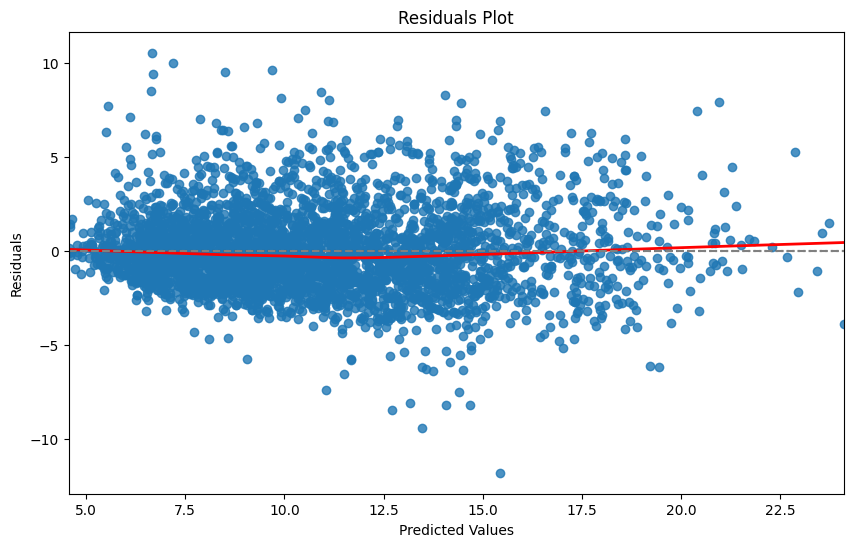

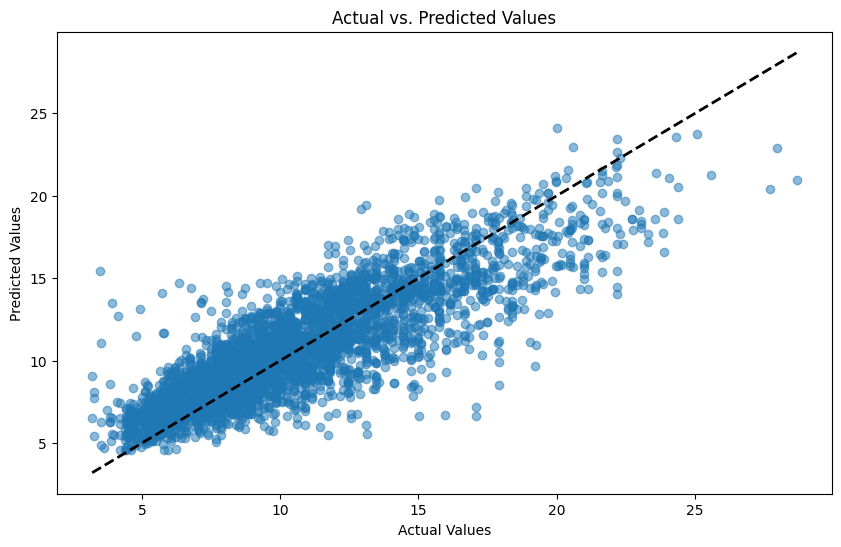

In [ ]:
#visualizing the result
y_pred_n = best_reg.predict(X_test_n)
plot_res_reg(y_test_n,y_pred_n)

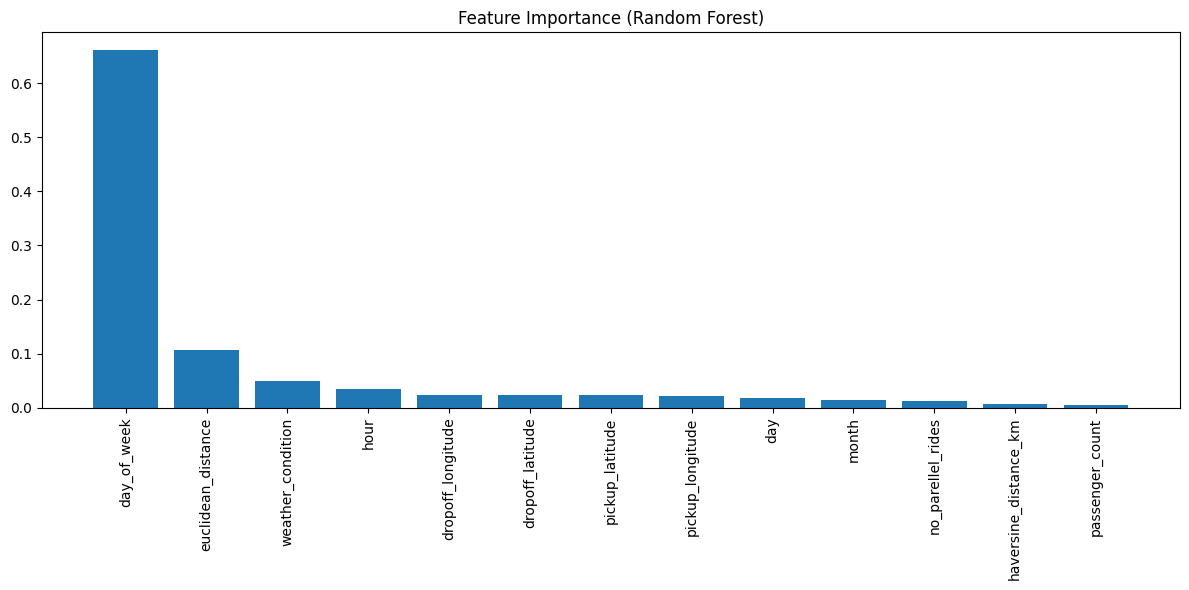

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

To a surprise feature importance no. of parallel rides rather decreased and also the performance evaluation metric that is MSE took a toll. There can be reasons such as

1) The Data Loss as a result of down sampling

2) Also, some of the rides based entries that we are up sampling has so less value that up sampling using smote is working adversely.

## Muller Loop and Plots for Weather Downsampled

In [ ]:
X_train_w, y_train_w = weather_downsampled.drop('updated_fare_amount', axis = 1), weather_downsampled['updated_fare_amount']

In [ ]:
X_test_w, y_test_w  = X_test[X_train_w.columns], y_test

In [ ]:
best_reg, result = run_muller_loop('DownscalingWeather',X_train_w,y_train_w,X_test_w,y_test_w)

Epoch 1/5
438/438 [==============================] - 2s 3ms/step - loss: 6.3754 - val_loss: 5.2152
Epoch 2/5
438/438 [==============================] - 1s 3ms/step - loss: 3.3420 - val_loss: 5.1916
Epoch 3/5
438/438 [==============================] - 2s 4ms/step - loss: 3.3066 - val_loss: 4.9180
Epoch 4/5
438/438 [==============================] - 2s 5ms/step - loss: 3.2579 - val_loss: 4.9031
Epoch 5/5
117/117 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 5.036104
Mean Absolute Error (MAE): 1.759492
R-squared (R2): 0.684350
For MLP Regressor MSE 5.036104077310797, Training Time = 11.629059
Mean Squared Error (MSE): 4.922879
Mean Absolute Error (MAE): 1.690209
R-squared (R2): 0.691447
For Linear Regression MSE 4.922878874333349, Training Time = 0.018423
Mean Squared Error (MSE): 4.493736
Mean Absolute Error (MAE): 1.599151
R-squared (R2): 0.718344
For Random Forest Regressor MSE 4.493735506579299, Training Time = 14.067267
Mean Squared Error (MSE): 8.254337
Me

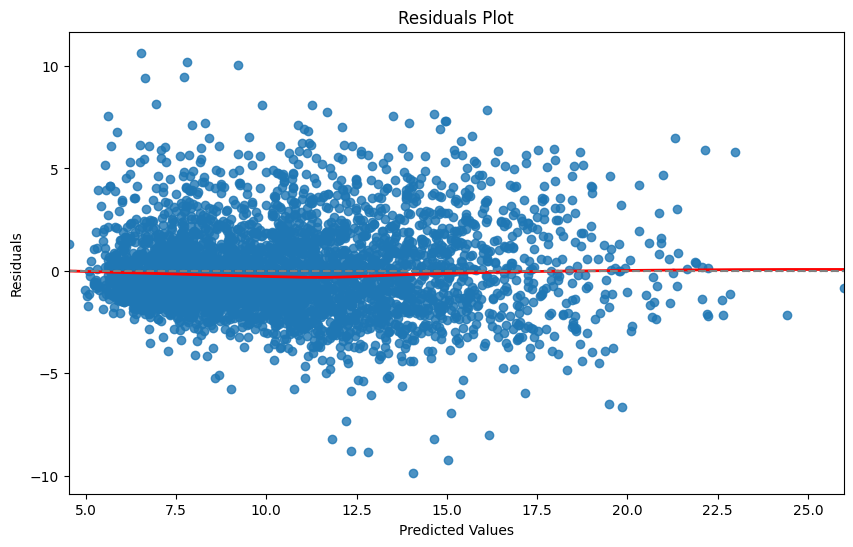

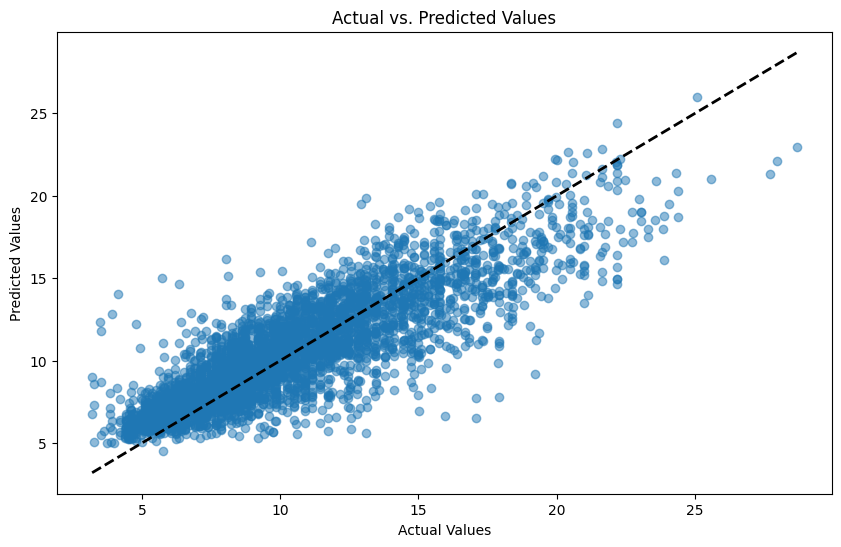

In [ ]:
#visualizing the result
y_pred_w = best_reg.predict(X_test_w)
plot_res_reg(y_test_n,y_pred_w)

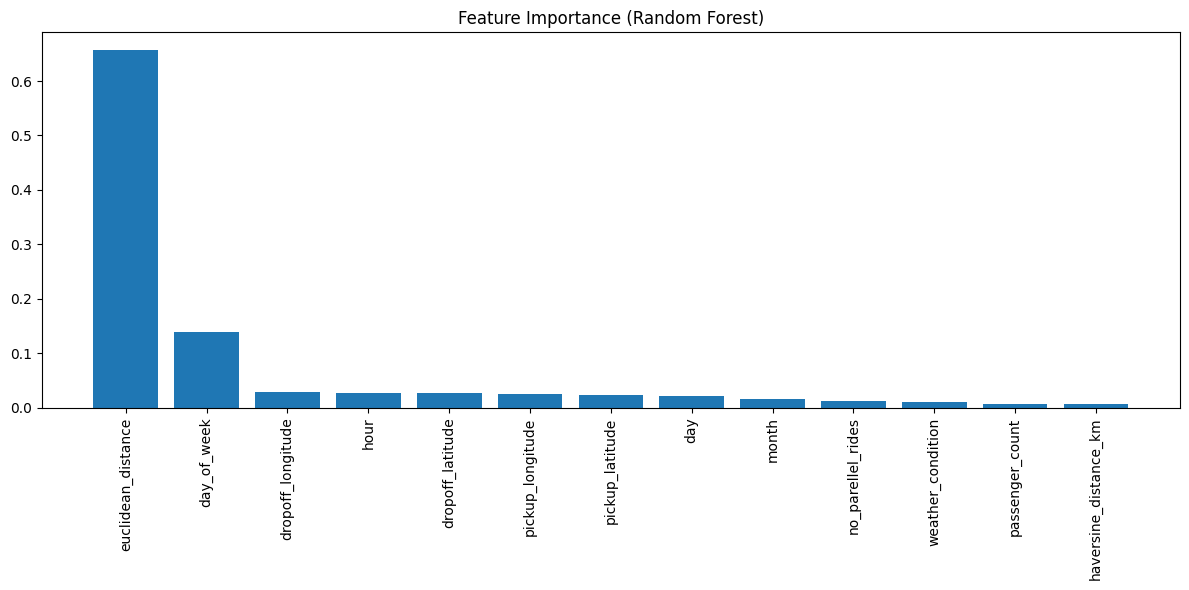

In [ ]:
feature_importances_rf = best_reg.feature_importances_
# Sort the feature importance in descending order
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_rf], rotation=90)
plt.tight_layout()
plt.show()

The case here is similar to that of downsampling no. of parallel rides as feature importance of no. of Weather condition rather decreased and also the performance evaluation metric that is MSE took a toll. There reasons might be similar.

In [ ]:
import pandas as pd
import os
import numpy as np
import pickle
import json

path = '/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/data_distribution_muller_result'

dictionaries  = []
for i in os.listdir(path):
  #get the name of the muller loop iteration
  with open(os.path.join(path,i),'rb') as f:
    dictionaries.append(pickle.load(f))

json_data = json.dumps(dictionaries)
# Convert JSON data to a Python object
data = json.loads(json_data)

# Create a list to hold the hierarchical data
hierarchical_data = []

# Iterate through the top-level array
for scenario in data:
    for scenario_name, models in scenario.items():
        # Iterate through the models array
        for model in models:
            for model_name, metrics in model.items():
                # Add a row for each model with the scenario, model, and metrics
                hierarchical_data.append((scenario_name, model_name, metrics['MSE'], metrics['MAE'], metrics['R2']))

# Convert the list to a DataFrame
columns = ['Scenario', 'Model', 'MSE', 'MAE', 'R2']
df = pd.DataFrame(hierarchical_data, columns=columns)

# Set the index to be hierarchical (Scenario, Model)
df.set_index(['Scenario', 'Model'], inplace=True)
df_html = df.to_html()
# Save the HTML to a file
with open('df.html', 'w') as file:
    file.write(df_html)

In [ ]:
df

MSE  \
Scenario                                   Model                               
UpScalingWeatherIndicator                  MLP Regressor            4.651140   
                                           Linear Regression        4.688006   
                                           Random Forest Regressor  4.060751   
                                           KNN Regressor            6.606438   
                                           XGBoost Regressor        9.286649   
NoUpScaling                                MLP Regressor            5.598337   
                                           Linear Regression        4.514431   
                                           Random Forest Regressor  3.925004   
                                           KNN Regressor            6.795103   
                                           XGBoost Regressor        8.973752   
UpScalingParellelRides                     MLP Regressor            4.513374   
                                           Linear Regression        4.730048   
                                           Random Forest Regressor  4.031901   
                                           KNN Regressor            7.309475   
                                           XGBoost Regressor        8.989846   
UpScalingParellelRidesWeather              MLP Regressor            4.557507   
                                           Linear Regression        4.774729   
                                           Random Forest Regressor  4.149316   
                                           KNN Regressor            7.601971   
                                           XGBoost Regressor        9.151853   
UpScalingParellelRidesIndicator            MLP Regressor            4.506226   
                                           Linear Regression        4.744916   
                                           Random Forest Regressor  4.064828   
                                           KNN Regressor            5.610842   
                                           XGBoost Regressor        7.554075   
UpScalingParellelIndicatorWeatherIndicator MLP Regressor            4.320526   
                                           Linear Regression        4.748890   
                                           Random Forest Regressor  4.043110   
                                           KNN Regressor            5.827460   
                                           XGBoost Regressor        7.540214   
DownscalingRides                           MLP Regressor            5.030417   
                                           Linear Regression        5.229536   
                                           Random Forest Regressor  4.565431   
                                           KNN Regressor            8.661579   
                                           XGBoost Regressor        9.787493   
DownscalingWeather                         MLP Regressor            5.036104   
                                           Linear Regression        4.922879   
                                           Random Forest Regressor  4.493736   
                                           KNN Regressor            8.254337   
                                           XGBoost Regressor        9.596702   

                                                                         MAE  \
Scenario                                   Model                               
UpScalingWeatherIndicator                  MLP Regressor            1.617669   
                                           Linear Regression        1.646284   
                                           Random Forest Regressor  1.506585   
                                           KNN Regressor            1.997720   
                                           XGBoost Regressor        2.419601   
NoUpScaling                                MLP Regressor            1.711616   
                                           Linear Regression        1.61

# Dashbaord and Visualization

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

In [ ]:
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/all_uber_data_cleaned_with_parellel_ride_and_weather.csv')

In [ ]:
data.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'euclidean_distance', 'date',
       'time', 'day_of_week', 'haversine_distance_km', 'year', 'month', 'day',
       'hour', 'minutes', 'seconds', 'updated_fare_amount',
       'no_parellel_rides', 'weather_condition'],
      dtype='object')

In [ ]:

#performing a train test split
X = data.drop(['year','updated_fare_amount','date','time','day','month','seconds','minutes'],axis=1)
y = data['updated_fare_amount']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
#combining training data as we would be applying sampling on just that
train  = X_train.copy()
train['updated_fare_amount'] = y_train

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14964 entries, 14234 to 2575
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pickup_longitude       14964 non-null  float64
 1   pickup_latitude        14964 non-null  float64
 2   dropoff_longitude      14964 non-null  float64
 3   dropoff_latitude       14964 non-null  float64
 4   passenger_count        14964 non-null  float64
 5   euclidean_distance     14964 non-null  float64
 6   day_of_week            14964 non-null  int64  
 7   haversine_distance_km  14964 non-null  float64
 8   hour                   14964 non-null  int64  
 9   no_parellel_rides      14964 non-null  int64  
 10  weather_condition      14964 non-null  int64  
 11  updated_fare_amount    14964 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 1.5 MB


Column
    [0] Markdown(str)
    [1] Row
        [0] Select(options=['no_parellel_rides', ...], value='no_parellel_rides')
        [1] IntSlider(end=10, name='Adjust Distribution', start=-10, width=400)
    [2] Markdown(None)
    [3] Matplotlib(None)
    [4] Matplotlib(None)
    [5] Markdown(str)
    [6] Row
        [0] Select(options=['Linear Regression', ...], value='Linear Regression')

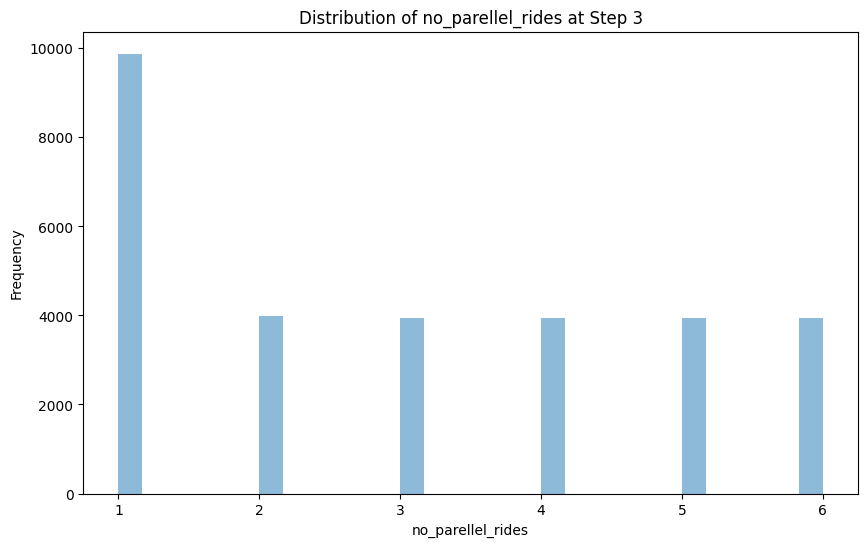

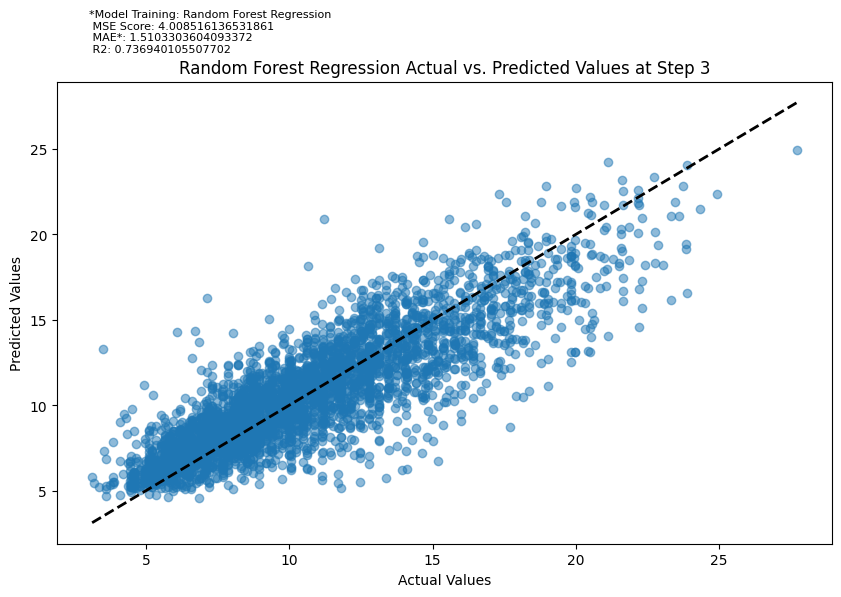

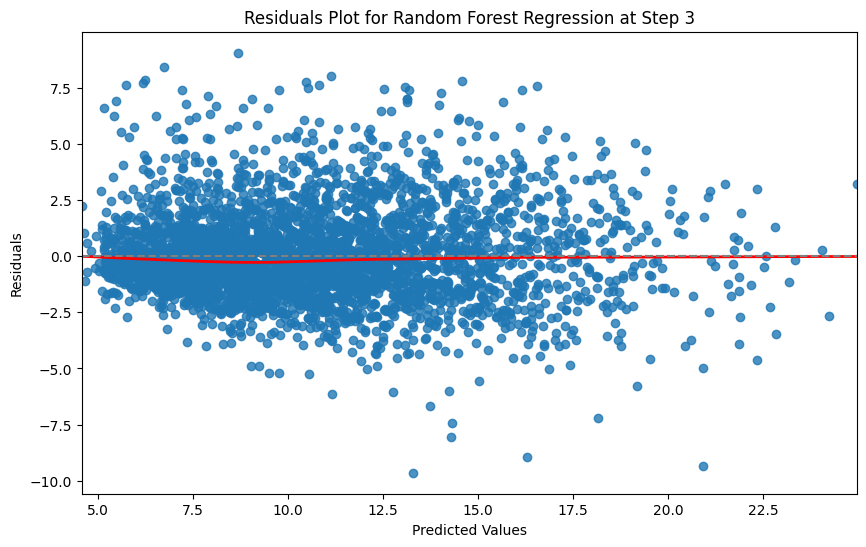

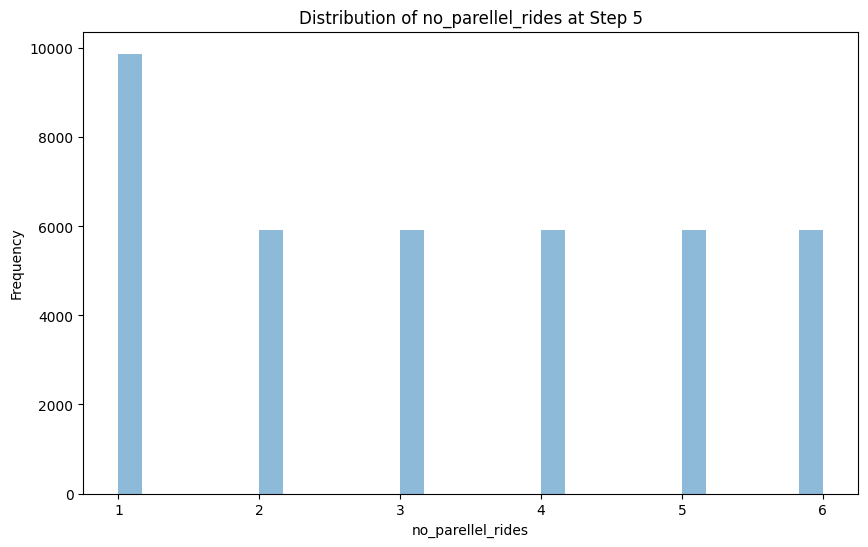

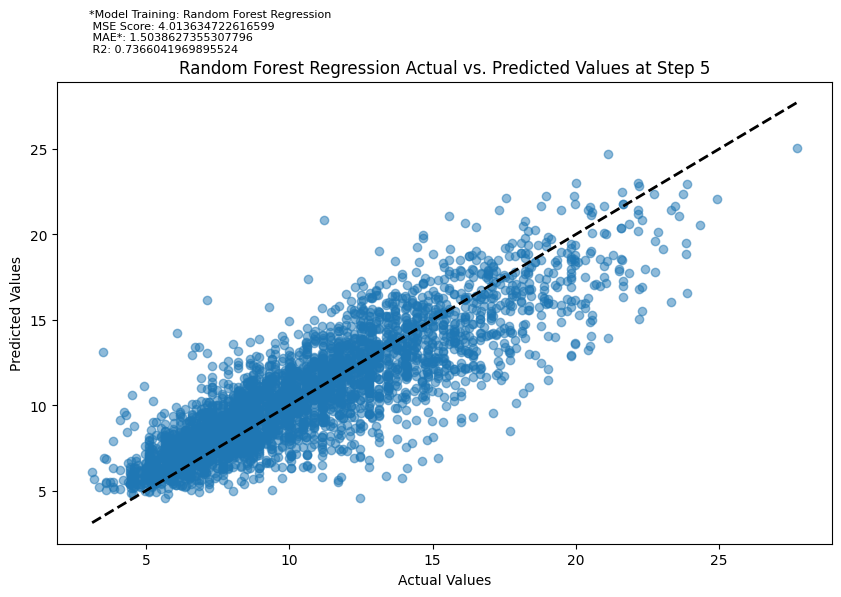

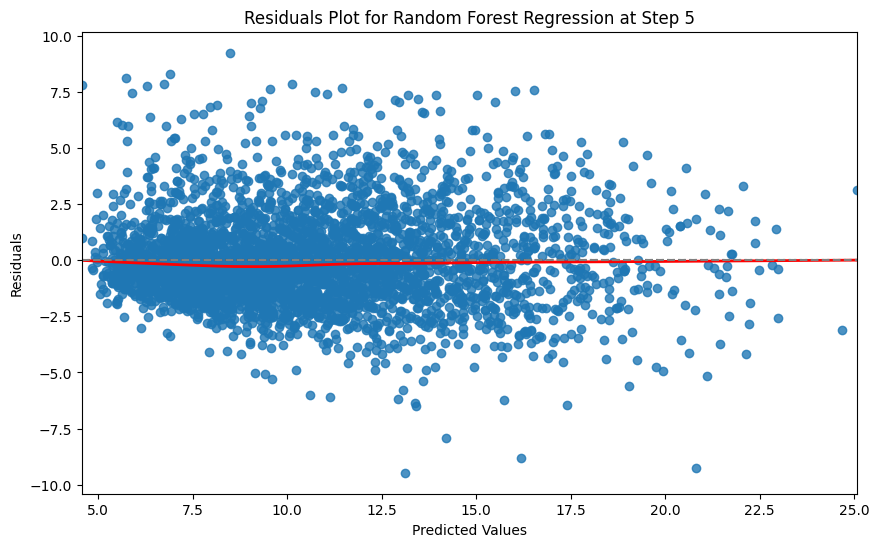

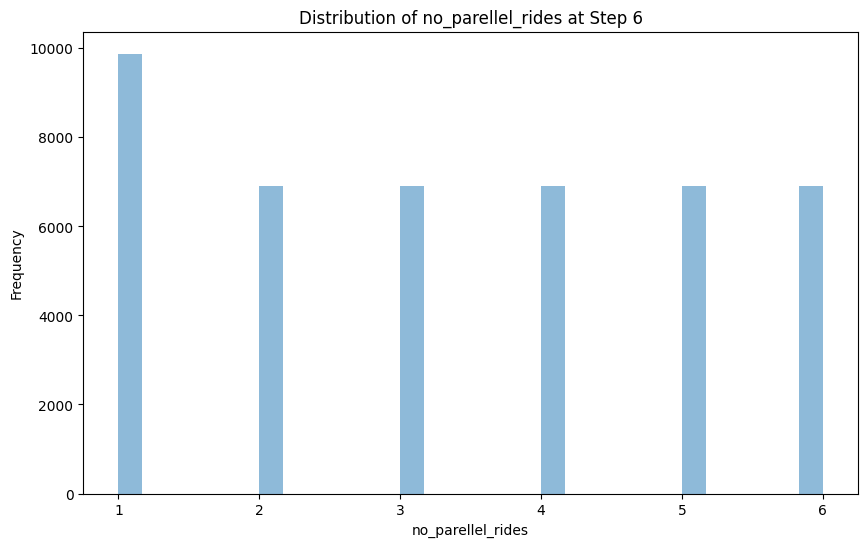

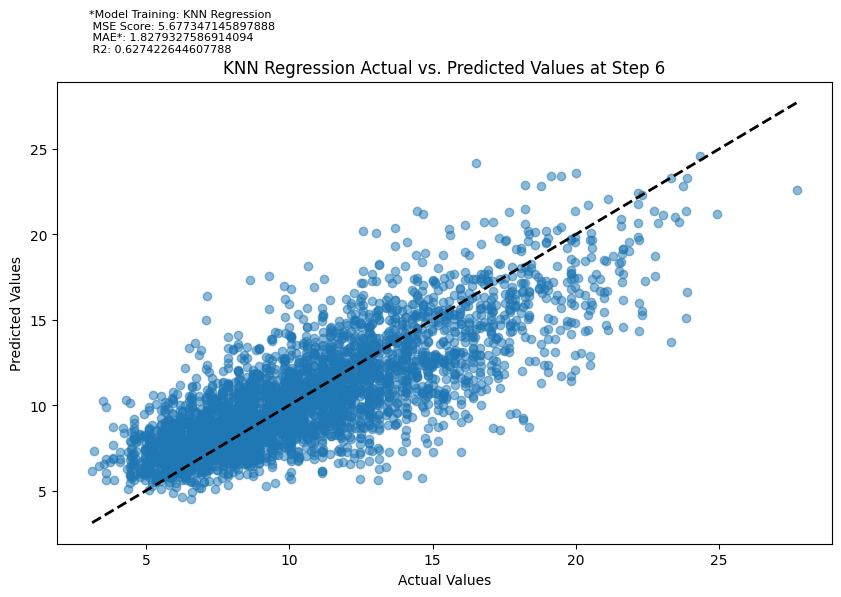

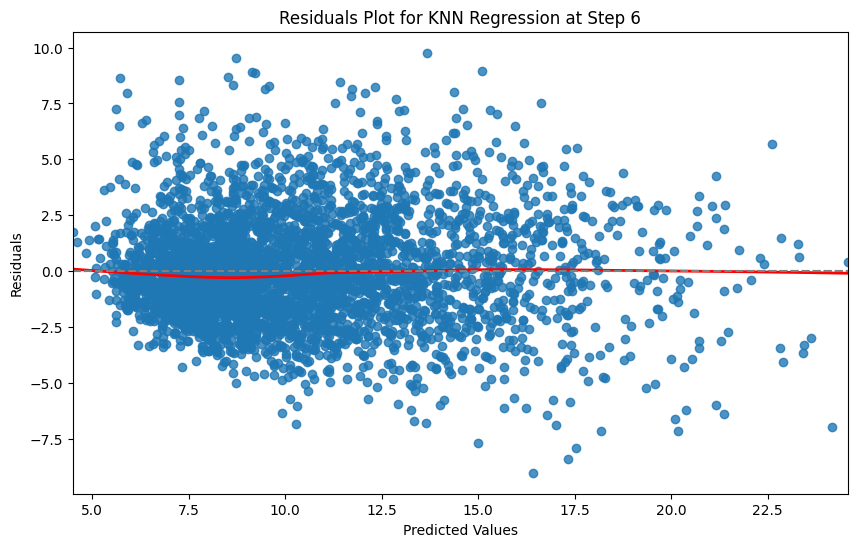

In [ ]:
import panel as pn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

pn.extension()

# Function Definitions
# # Dummy dataset
# data = pd.DataFrame({
#     'Feature1': np.random.randn(100),
#     'Feature2': np.random.rand(100),
#     'Target': np.random.choice([0, 1], 100)
# })

#Initialize Linear Regressor
lr = LinearRegression()

#Initialize RandomForest Regressor

rf = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest
                               max_depth=None,    # Maximum depth of the trees
                               random_state=42)   # Seed for reproducibility

# Initialize the KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)

models = {'Linear Regression': lr, 'KNN Regression': knn_reg,'Random Forest Regression':rf}

def upsampling(data, feature,step):
    x = data.drop([feature],axis=1)
    y = X_train[feature]
    # Find the majority class and its count
    class_counts = y.value_counts()
    majority_class = class_counts.idxmax()
    majority_count = class_counts.max()
    min_count= class_counts.min()
    step = 0.1+(0.1*step)
    # Set the sampling strategy for each minority class to match the majority class count
    sampling_strategy = {class_label: max(class_counts[class_label],round(majority_count*step)) for class_label in class_counts.index if class_counts[class_label] < majority_count}
    if feature != 'weather_condition':
      smote = SMOTE(sampling_strategy=sampling_strategy,random_state=42)
    else:
      smote = SMOTE(sampling_strategy=sampling_strategy,random_state=42,k_neighbors=2)

    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(x,y)

    # # Check the class distribution after SMOTE
    # print(f"Original class distribution: {data[feature].value_counts()}")
    # print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts()}")

    #combining them
    #now we will combine the smote data to make the main data
    balanced_data = X_train_smote.copy()
    balanced_data[feature] =y_train_smote
    return balanced_data




def downsample(data, feature, step):
    # Function to downsample the category
    def downsample_category(df, slider, category_values):
        # Filter the category
        i = 0
        for category_value in category_values:
          if i == 0:
            df_filtered = df[df['no_parellel_rides'] == category_value]
            df_downsampled = df_filtered.sample(n=100*slider, replace = True, random_state=42)
            i = 1
          else:
            df_filtered = df[df['no_parellel_rides'] == category_value]
            add = df_filtered.sample(n=100*slider, replace = True, random_state=42)
            df_downsampled = pd.concat([df_downsampled, add], axis = 0)

        return df_downsampled
    step += 20
    # Downsample categories 1 and 2
    downsampled_data = downsample_category(data, step, list(data[feature].unique()))
    return downsampled_data

def train_model(data, model_name):
    global X_test,y_test
    X_train  = data.drop('updated_fare_amount',axis=1)
    #making sure test and train have the same order of features
    X_train = X_train[X_test.columns]
    y_train = data['updated_fare_amount']
    #get the appropriate model object
    model = models[model_name]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse,mae,r2,y_test,y_pred

def specificity_sensitivity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return specificity, sensitivity


def plot_feature_distribution(df, feature,step):
    fig, ax = plt.subplots(figsize=(10, 6))
    df[feature].plot(kind='hist', bins=30, alpha=0.5, ax=ax)
    ax.set_title(f'Distribution of {feature} at Step {step}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    return fig

def plot_residual(y_test, y_pred,model_name,step):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'Residuals Plot for {model_name} at Step {step}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.show()


def plot_pred_true(y_test, y_pred,model_name,step):
    # Visualize the model fit
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
    ax.set_title(f'{model_name} Actual vs. Predicted Values at Step {step}')
    plt.text(3, 30, f'*Model Training: {model_name}\n MSE Score: {mse}\n MAE*: {mae}\n R2: {r2}\n', fontsize=8)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    res_fig = plot_residual(y_test, y_pred,model_name,step)
    return fig,res_fig

# Interactive Components

feature_selector = pn.widgets.Select(name='Select Feature', options=['no_parellel_rides', 'weather_condition'])
distribution_slider = pn.widgets.IntSlider(name='Adjust Distribution', start=-10, end=10, step=1, value=0, width=400)


model_selector = pn.widgets.Select(name='Select Model', options=[
    'Linear Regression', 'KNN Regression', 'Random Forest Regression'
])

train_button = pn.widgets.Button(name='Train Model', button_type='primary')

data_manipulation_results = pn.pane.Markdown()
model_training_results = pn.pane.Markdown()

data_manipulation_predicted_actual_plot = pn.pane.Matplotlib()
model_training_spec_sens_plot = pn.pane.Matplotlib()
data_distribution_plot = pn.pane.Matplotlib()
residual_plot = pn.pane.Matplotlib()

# Callbacks

def adjust_distribution(event):
    selected_feature = feature_selector.value
    if event.new > 0:
        modified_data = upsampling(train.copy(), selected_feature,event.new)
    else:
        modified_data = downsample(train.copy(), selected_feature,event.new)

    model_name=model_selector.value
    mse,mae,r2,y_true,y_pred= train_model(modified_data, model_selector.value)
    data_distribution_plot.object = plot_feature_distribution(modified_data, selected_feature,event.new)
    #model_training_results.object = f"*Model Training: {model_name}\MSE Score: {mse}\MAE*:\n{mae}\n R2: {r2}\n"

    data_manipulation_predicted_actual_plot.object,residual_plot.object = plot_pred_true(y_test, y_pred,model_name,event.new)

def train_selected_model(event):
    '''
    Not using this functio
    '''
    model_name = model_selector.value
    mse,mae,r2,y_true,y_pred = train_model(train.copy(), model_name)  # Assumes data.copy() is the modified dataset

    # data_distribution_plot.object = plot_feature_distribution(train,copy(), selected_feature,event.new)
    # model_training_results.object = f"*Model Training: {model_name}\MSE Score: {mse}\MAE*:\n{mae}\n R2: {r2}\n"
    # data_manipulation_predicted_actual_plot.object = plot_pred_true(y_test, y_pred,model_name,event.new)

distribution_slider.param.watch(adjust_distribution, 'value')
train_button.on_click(train_selected_model)

# Dashboard Layout

dashboard = pn.Column(
    "# Feature Selection and Distribution Adjustment",
    pn.Row(feature_selector, distribution_slider),
    data_manipulation_results,
    data_manipulation_predicted_actual_plot,
    residual_plot,
    "# Model Selection and Training",
    pn.Row(model_selector),

)

dashboard.servable()